# GAMMA RAY BURSTS
We know that the there are two sources of GRBs. So we expect to find two clusters in the data.
The first distinction between the two is the time: one astrophysical source emits shorter GRBs with respect to the other. So the fist thing we would like to do is look at the duration to see if we can see two modes:

In [2]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

In [3]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [4]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

[]

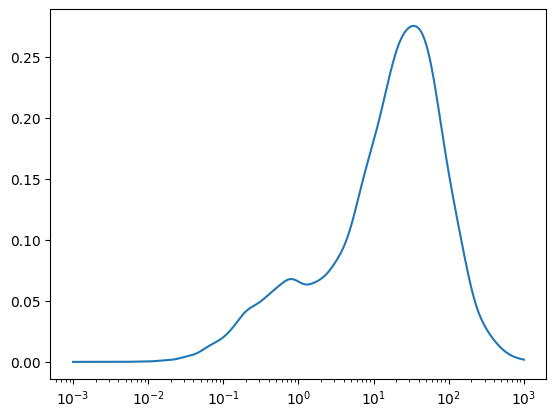

In [5]:
T90 = np.array(data[6, :], dtype = float)
T90_pos = T90[T90[:] > 0.0]

def kde_sklearn(data, bandwidth = 1.0):
    kde_skl = KernelDensity(kernel='gaussian', bandwidth = bandwidth)
    kde_skl.fit(np.log(data[:, np.newaxis]))
    log_pdf = kde_skl.score_samples(np.log(xgrid[:, np.newaxis])) # sklearn returns log(density)
    return np.exp(log_pdf)

bw_range = np.linspace(0.01, 0.5, 20)
grid = GridSearchCV(KernelDensity(), {'bandwidth':bw_range}, cv = 5)
grid.fit(np.log(T90_pos[:, np.newaxis]))
b_opt = grid.best_params_['bandwidth']

xgrid = np.logspace(-3, 3, 1000)
pdf = kde_sklearn(T90_pos, b_opt)
plt.plot(xgrid, pdf)
plt.semilogx()

We can see two modes. Now we can try to split the data into two clusters:

In [8]:
clust = KMeans(n_clusters=2)
clust.fit(np.log(T90_pos)[:, np.newaxis])
labels = clust.predict(np.log(T90_pos)[:, np.newaxis])

print(np.min(T90_pos[labels == 1]))
print(np.mean([np.max(T90_pos[labels == 0]), np.min(T90_pos[labels == 1])]))

0.008
1050.004


Text(0, 0.5, 'Redshift')

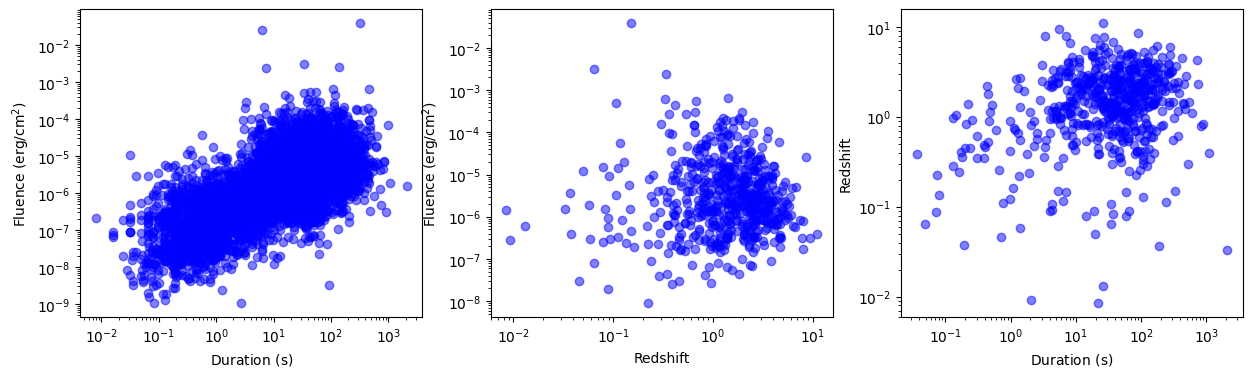

In [146]:
T90_vs_fluence = np.array([[data[6, i], data[9, i]] for i in range(len(data[0, :]))], dtype=float)
a = T90_vs_fluence[T90_vs_fluence[:,0] > 0.0]
T90_vs_f_pos = a[a[:, 1] > 0.0]

dist_vs_fluence = np.array([[data[11, i], data[9, i]] for i in range(len(data[0, :]))], dtype=float)
a = dist_vs_fluence[dist_vs_fluence[:, 1] > 0.0]
dist_vs_f_pos = a[a[:, 0] > 0.0]

T90_vs_dist = np.array([[data[6, i], data[11, i]] for i in range(len(data[0, :]))], dtype=float)
condition1 = (T90_vs_dist[:,0] > 0.0)
a = T90_vs_dist[T90_vs_dist[:,0] > 0.0]
T90_vs_dist_pos = a[a[:, 1] > 0.0]

plt.figure(figsize=[15, 4])
plt.subplot(1,3,1)
plt.scatter(T90_vs_f_pos[:, 0], T90_vs_f_pos[:, 1], c = 'blue', alpha = 0.5)
plt.semilogx()
plt.semilogy()
plt.xlabel(r"Duration ($\mathrm{s}$)")
plt.ylabel(r"Fluence ($\mathrm{erg/cm}^2$)")
plt.subplot(1,3,2)
plt.scatter(dist_vs_f_pos[:, 0], dist_vs_f_pos[:, 1], c = 'blue', alpha = 0.5)
plt.semilogx()
plt.semilogy()
plt.xlabel(r"Redshift")
plt.ylabel(r"Fluence ($\mathrm{erg/cm}^2$)")
plt.subplot(1,3,3)
plt.scatter(T90_vs_dist_pos[:, 0], T90_vs_dist_pos[:, 1], c = 'blue', alpha = 0.5)
plt.semilogx()
plt.semilogy()
plt.xlabel(r"Duration ($\mathrm{s}$)")
plt.ylabel(r"Redshift")

We can clearly see two modes in the first plot, indicating that the process that produces the shorter burts also produce the less energetic. Morover, neither the fluence nor the duration seem to depend on the distance, thus the relation between the two variables seems to be determined by the actual process undergoing.

Now we can try to find the two clusters. The first approach is using the K-means algorithm:

In [73]:
clust = KMeans(n_clusters=2)
clust.fit(np.log(T90_vs_f_pos))
labels = clust.predict(np.log(T90_vs_f_pos))

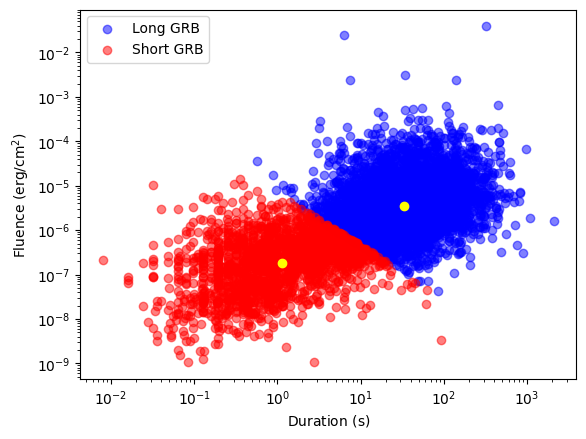

In [138]:
plt.scatter(T90_vs_f_pos[labels == 0, 0], T90_vs_f_pos[labels == 0, 1], c = 'blue', alpha = 0.5, label = "Long GRB")
plt.scatter(T90_vs_f_pos[labels == 1, 0], T90_vs_f_pos[labels == 1, 1], c = 'red', alpha = 0.5, label = "Short GRB")
#plt.scatter(np.exp(clust.cluster_centers_[0, 0]), np.exp(clust.cluster_centers_[0, 1]), c = 'yellow')
#plt.scatter(np.exp(clust.cluster_centers_[1, 0]), np.exp(clust.cluster_centers_[1, 1]), c = 'yellow')
plt.semilogx()
plt.semilogy()
plt.xlabel(r"Duration ($\mathrm{s}$)")
plt.ylabel(r"Fluence ($\mathrm{erg/cm}^2$)")
plt.legend()

In [153]:
clust.predict(np.log([[1, 1*10**-4]]))

array([0], dtype=int32)

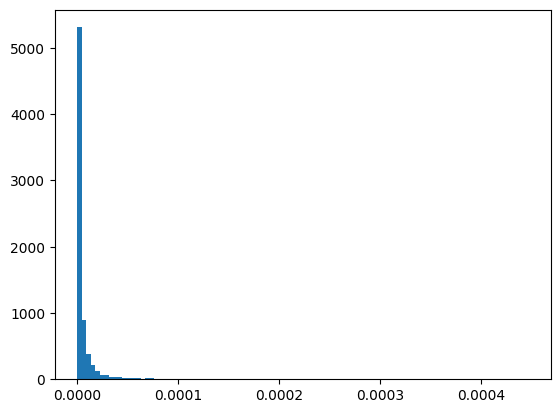

In [143]:
np.median(T90_vs_f_pos[:, 1])
T90_vs_f_pos[T90_vs_f_pos[:, 1] < 1e-3]
_ = plt.hist(T90_vs_f_pos[T90_vs_f_pos[:, 1] < 5e-4][:, 1], bins = 100)

In [118]:
#bandwidth = estimate_bandwidth(T90_vs_f_pos)
cl_ms = MeanShift(bandwidth=2, bin_seeding=True, cluster_all=False)
cl_ms.fit(np.log(T90_vs_f_pos))
labels_ms = cl_ms.predict(np.log(T90_vs_f_pos))
print(np.unique(labels_ms))
print(bandwidth)

[0 1 2]
29.24384494031026


Text(0, 0.5, 'Fluence ($\\mathrm{erg/cm}^2$)')

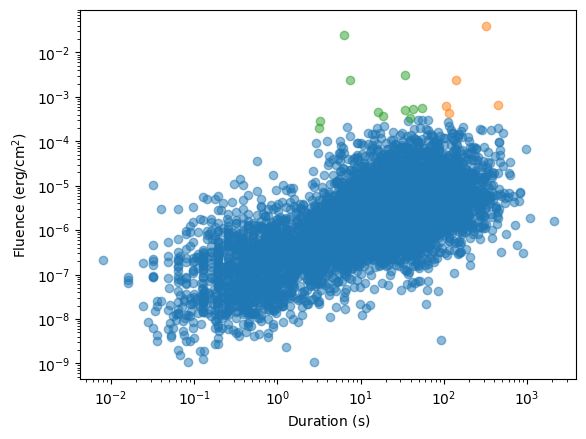

In [119]:
for i in np.unique(labels_ms):
    plt.scatter(T90_vs_f_pos[labels_ms == i, 0], T90_vs_f_pos[labels_ms == i, 1], alpha = 0.5)
plt.semilogx()
plt.semilogy()
plt.xlabel(r"Duration ($\mathrm{s}$)")
plt.ylabel(r"Fluence ($\mathrm{erg/cm}^2$)")

In [80]:
from sklearn import preprocessing
? preprocessing.StandardScaler

Init signature:  preprocessing.StandardScaler(*, copy=True, with_mean=True, with_std=True)
Docstring:     
Standardize features by removing the mean and scaling to unit variance.

The standard score of a sample `x` is calculated as:

    z = (x - u) / s

where `u` is the mean of the training samples or zero if `with_mean=False`,
and `s` is the standard deviation of the training samples or one if
`with_std=False`.

Centering and scaling happen independently on each feature by computing
the relevant statistics on the samples in the training set. Mean and
standard deviation are then stored to be used on later data using
:meth:`transform`.

Standardization of a dataset is a common requirement for many
machine learning estimators: they might behave badly if the
individual features do not more or less look like standard normally
distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of
a learning algorithm (such as the RBF k